In [7]:
import jax
import jax.numpy as jnp

from newton_smoothers.base import MVNStandard, FunctionalModel
from newton_smoothers.approximation import quadratize
from newton_smoothers import trust_region_iterated_recursive_newton_smoother

import matplotlib.pyplot as plt

from bearing_data import get_data, make_parameters

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)


s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1.0, 1.0])  # Second sensor location
r = 0.5  # Observation noise (stddev)
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location

dt = 0.01  # discretization time step
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 500  # number of observations
nx, ny = 5, 2

_, true_states, observations = get_data(x0, dt, r, T, s1, s2)
Q, R, trans_fcn, obsrv_fcn, _, _ = make_parameters(qc, qw, r, dt, s1, s2)

trans_mdl = FunctionalModel(trans_fcn, MVNStandard(jnp.zeros((nx,)), Q))
obsrv_mdl = FunctionalModel(obsrv_fcn, MVNStandard(jnp.zeros((ny,)), R))

init_dist = MVNStandard(
    mean=jnp.array([-1.0, -1.0, 0.0, 0.0, 0.0]),
    cov=jnp.eye(nx)
)

init_nominal = MVNStandard(
    mean=jnp.zeros((T + 1, nx)),
    cov=jnp.repeat(jnp.eye(nx).reshape(1, nx, nx), T + 1, axis=0),
)
init_nominal.mean.at[0].set(init_dist.mean)
init_nominal.cov.at[0].set(init_dist.cov)

smoothed, costs = trust_region_iterated_recursive_newton_smoother(
    init_nominal,
    observations,
    init_dist,
    trans_mdl,
    obsrv_mdl,
    quadratize,
    nb_iter=25,
)

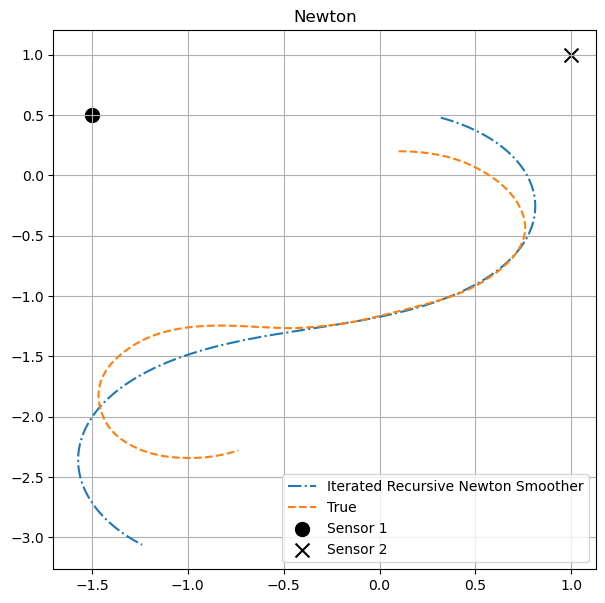

In [6]:
plt.figure(figsize=(7, 7))
plt.plot(
    smoothed.mean[:, 0],
    smoothed.mean[:, 1],
    label="Iterated Recursive Newton Smoother",
    linestyle='-.'
)
plt.plot(true_states[:, 0], true_states[:, 1], label="True", linestyle='--')
plt.scatter(*s1, marker="o", s=100, label="Sensor 1", color='k')
plt.scatter(*s2, marker="x", s=100, label="Sensor 2", color='k')
plt.title("Newton")
plt.grid()
plt.legend()
plt.show()